## Import

In [1]:
import numpy as np
import pandas as pd
import import_ipynb
import io
import networkx as nx
import pydot
from io import BytesIO
from IPython.display import Image

## QI Selection

In [2]:
df = pd.read_csv('Dataset/Dataset-8k.csv')
print(df)

        ID                Name                                    Email  \
0        1         Nathan Roth          Nathan_Roth1584442004@brety.org   
1        2         Abbey Grady         Abbey_Grady1526558097@supunk.biz   
2        3         Mike Rivers           Mike_Rivers125936120@twace.org   
3        4        Harry Hunter        Harry_Hunter1608989927@bungar.biz   
4        5       Ally Truscott       Ally_Truscott2033161446@ovock.tech   
...    ...                 ...                                      ...   
7995  7996  Nicholas Armstrong  Nicholas_Armstrong1786717544@nimogy.biz   
7996  7997     Alexander Trent       Alexander_Trent225920544@tonsy.org   
7997  7998      Ronald Edwards        Ronald_Edwards202912605@tonsy.org   
7998  7999        Fred Gardner        Fred_Gardner1951456777@famism.biz   
7999  8000         Ron Shields        Ron_Shields2055808448@joiniaa.com   

      Gender  Age                   Street    Zip  
0       Male   40        Clyde Drive, 3171  161

In [3]:
df['Gender'] = df['Gender'].astype('string')
df['Gender'] = df['Gender'].replace("Male","0").replace("Female","1")
df['Gender'] = df['Gender'].astype('int64')
qi=['Zip','Gender']
dfQI= pd.DataFrame(df, columns = qi)

In [4]:
print(dfQI)

        Zip  Gender
0     16171       0
1     16104       1
2     16188       0
3     16147       0
4     16106       1
...     ...     ...
7995  16183       0
7996  16176       0
7997  16125       0
7998  16158       0
7999  16106       0

[8000 rows x 2 columns]


# Generation of Graph

## Initialization

In [5]:

graph = nx.DiGraph()

d1 = 3 # dimension of 1 feature || Specific column : Level of Generalization || Zip
d2 = 2 # dimension of 2 feature || Specific column : Level of Generalization || Gender
k = 1000

nodes = []
edges = []

## Generating the graph using DFS with recursion

In [6]:
def addEdge(e1, e2):
    edges.append((e1, e2))

def concat(a, b):
    a1 = str(a)
    b1 = str(b)
    return str(f"{a1}{b1}")
                
def recursive(f1,f2):

    s = str(f1) + '' + str(f2)
    #(12)
    if s not in nodes:
        #print(s) [(0,0),(0,1),(0,2),(1,2),(2,2)]
        nodes.append(s)    
    
    # Go deeper on left side
    if(f2 < d2):
        d = str(f1) + '' + str(f2+1)
        ##(02)
        addEdge(concat(f1,f2), concat(f1,f2+1))
        # (0,1) -> (0,2)
        if d not in nodes:
            recursive(f1,f2+1)

    # Go deeper on right side
    if(f1 < d1):
        d = str(f1+1) + '' + str(f2)
        ##(2,2)
        addEdge(concat(f1,f2), concat(f1+1,f2))
        ##(1,2) -> (2,2)
        if d not in nodes:
            recursive(f1+1,f2)

## Generation of Graph 

In [7]:
#Pass the root node
recursive(0,0)

print(nodes)
print(edges)

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)


['00', '01', '02', '12', '22', '32', '11', '21', '31', '10', '20', '30']
[('00', '01'), ('01', '02'), ('02', '12'), ('12', '22'), ('22', '32'), ('01', '11'), ('11', '12'), ('11', '21'), ('21', '22'), ('21', '31'), ('31', '32'), ('00', '10'), ('10', '11'), ('10', '20'), ('20', '21'), ('20', '30'), ('30', '31')]


## Save the graph as image

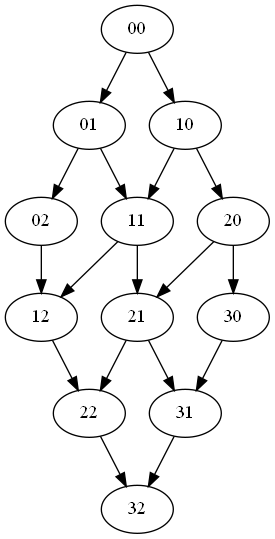

In [8]:
def displayGraph(graph):
    pydot_graph =nx.drawing.nx_pydot.to_pydot(graph)
    plt = Image(pydot_graph.create_png())
    display(plt)
    
displayGraph(graph)

## Iterating each node
### Generate a new dataset using Generalization

In [9]:
feature_generalization = { 'Gender':'replace', 'Zip': 'suppression'}
feature_dimension = { 'Gender': 2, 'Zip': 3}
feature_replace = { 'Gender': 'Person', 'Zip': ''}

In [10]:
def generalization(data, feature, type, dimension, replaceValue):
    cData = pd.DataFrame(data=data, columns=[feature]) 
    
    if int(dimension) < 1:
        return data[feature]
    
    if type == 'suppression':
        count = -1
        count = count * int(dimension) # -1 * 2 = -2
        cData = cData[feature].map(lambda x: str(x)[:count] if len(str(x)[:count]) is not 0 else 0 ).astype(int)
        
        # str(x) 12345 [:-2] [starting, length] 123
      
    elif type == 'range':
        diff = (cData[feature].min().astype(str)  + '-' + cData[feature].max().astype(str) )
        cData[feature] = diff
        cData = cData[feature].squeeze()
    
    elif type == 'replace':
        cData[feature] = replaceValue
        cData = cData[feature].squeeze()
    
    return cData

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Aleem\AppData\Local\Temp\ipykernel_15092\1824846553.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cData = cData[feature].map(lambda x: str(x)[:count] if len(str(x)[:count]) is not 0 else 0 ).astype(int)


In [11]:
def generate_dataset(node):
    #node = (0,1)
    #featu= (zip, Gender)
    df = pd.DataFrame(columns=qi) # empty dataset
    
    index = 0
    for d in str(node):
        feature = qi[index] # SEX 
        print('Feature: ', feature)
        print('Dimension: ', d)
        df[feature] =  generalization(dfQI
                                      , feature
                                      , feature_generalization[feature]
                                      , d
                                      , feature_replace[feature])
        index =+ 1
    return df

### Check if dataset of this node is K-Anonymous

In [12]:

def isKAnonymized(df, attributes, k):

    #Attributes = Quasi Identifiers
    #Corner Case: If Data set is small than K. Returns false
    if k > df.shape[0]: return False

    #attributes = ['Zip','Gender']
    grouped = df.groupby(attributes)

    for name,group in grouped:
        print('No of Rows Grouped:',group.shape[0])
        
        if group.shape[0] < k:
            return False

    return True

### Marked it
### Marked all the linked nodes (bottom to top)

In [13]:
def markNodes(graph, node):
    linked_nodes = list(nx.bfs_tree(graph, source=node ).nodes())
    for node in linked_nodes:
        nx.set_node_attributes(graph, {node:{'k':True}})
        graph.nodes[node]['color'] = 'red'
    print('Marked:',linked_nodes)
    return graph

### Iterate nodes as BFS 

In [14]:
#Get graph with bfs
bfs_nodes = list(nx.bfs_tree(graph, source='00').nodes())

print(bfs_nodes)

['00', '01', '10', '02', '11', '20', '12', '21', '30', '22', '31', '32']


## Incognito
#### ~ Generate a new dataset using Generalization
#### ~ Check if dataset of this node is K-Anonymous
#### ~ Marked it
#### ~ Marked all the linked nodes (bottom to top)

In [15]:
index = 0

for node in bfs_nodes:
    print('--------')
    print('Node: ', node)
    
    n = graph.nodes[node]
    if n.get('k') is not None and n['k']:
        print('Alread marked node:', node)
    else:
        print('Not marked node:', node)
    
        dataset = generate_dataset(str(node))
        print(dataset)

        isKAnonymize = isKAnonymized(dataset, qi, k)

        if isKAnonymize:
            print('node', node,' is K-Anonymized', isKAnonymize)
            markNodes(graph, node)
        else:
            print('node', node,' is Not K-Anonymized', isKAnonymize)
    
    print('')

--------
Node:  00
Not marked node: 00
Feature:  Zip
Dimension:  0
Feature:  Gender
Dimension:  0
        Zip  Gender
0     16171       0
1     16104       1
2     16188       0
3     16147       0
4     16106       1
...     ...     ...
7995  16183       0
7996  16176       0
7997  16125       0
7998  16158       0
7999  16106       0

[8000 rows x 2 columns]
No of Rows Grouped: 34
node 00  is Not K-Anonymized False

--------
Node:  01
Not marked node: 01
Feature:  Zip
Dimension:  0
Feature:  Gender
Dimension:  1
        Zip  Gender
0     16171  Person
1     16104  Person
2     16188  Person
3     16147  Person
4     16106  Person
...     ...     ...
7995  16183  Person
7996  16176  Person
7997  16125  Person
7998  16158  Person
7999  16106  Person

[8000 rows x 2 columns]
No of Rows Grouped: 71
node 01  is Not K-Anonymized False

--------
Node:  10
Not marked node: 10
Feature:  Zip
Dimension:  1
Feature:  Gender
Dimension:  0
       Zip  Gender
0     1617       0
1     1610       1
2

### Display the graph after marking

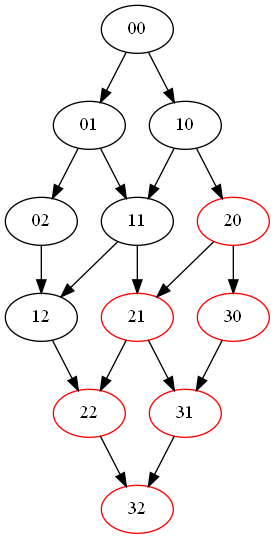

In [16]:
displayGraph(graph)